This code uses built-in functions from the Image class in PIL to execute isometries on a given image. It snapshots the lens view after each isometry, then puts those images into a numpy array. It then calculates the persistent homology of the data. For different images, 'lens_sz' and 'intervals' should be adjusted.

In [1]:
# Imports
import numpy as np
import math

# For image and video manipulation
from PIL import Image
from PIL import ImageEnhance
from PIL import ImageFilter
import PIL
import glob

# Persistent homology
from ripser import ripser
from persim import plot_diagrams

import matplotlib.pyplot as plt
%matplotlib inline

In [23]:
# Grab image from files
img_names = glob.glob('images/*C1bigarrows.png')
img = Image.open(img_names[0])
# with np.printoptions(threshold=np.inf):
#     print(np.asarray(img))

img = img.convert('L')
# with np.printoptions(threshold=np.inf):
#     print(np.asarray(img))
#img = img.resize((540,331), resample = PIL.Image.Resampling.BOX)
#img = ImageEnhance.Sharpness(img.convert('RGB'))
#img = img.enhance(0.1)
#img = img.filter(ImageFilter.GaussianBlur(1))

#img.show()

translation_snapshot() translates the plane by a vector a and returns the lens view afterwards. It takes an image (Image), the lens size (int), and the translation vector (tuple) that shifts the plane in the direction of the vector. 

In [24]:
def translation_snapshot(img, lens_sz, a):
    (x,y)=a
    x=-x #since x and y will shift the crop and not the plane, need to make sure it is going in right direction
    (length, height) = img.size
    lens_corner_x=length/2.0 - lens_sz/2.0 +x
    lens_corner_y=height/2.0 - lens_sz/2.0 +y
    ret_img = img.crop((lens_corner_x,lens_corner_y, lens_corner_x+lens_sz, lens_corner_y+lens_sz))
    
    #make sure didn't fall off of the image
    (ret_length, ret_height) = ret_img.size
    if (lens_corner_x<0 or lens_corner_y<0 or lens_corner_x+lens_sz>length or lens_corner_y+lens_sz>height):
        print("I came off the page!")
        return False
    return ret_img

In [60]:
# adjustable variables
lens_sz = 300
degree_num = 72
translation_num = 5
rng = np.random.default_rng(451)
# note lens size should be dividable by crunch kernel if lens crunch is true
lens_crunch = False
crunch_kernel = 3
image_list = []
# this should probably be false, other option produces poor results. Only matters for first snapshot method.
random_intervals = False
zero_translations = 50

# this range depends on image size and lens size such that the lens doesn't come off the page
lens_range = ((min(img.size)/math.sqrt(2))-lens_sz)/2.0

degrees = np.linspace(0, 360, degree_num)



if not random_intervals:
    intervals_x = np.linspace((-1)*lens_range, lens_range, translation_num)
    intervals_y = np.linspace((-1)*lens_range, lens_range, translation_num)
else:
    intervals_x = rng.integers((-1)*lens_range, lens_range, size = translation_num)
    intervals_y = rng.integers((-1)*lens_range, lens_range, size = translation_num)

print(intervals_x)
# take snapshot images
# for d in degrees:
#     print(d)
#     rot = img.rotate(d,resample = PIL.Image.Resampling.BICUBIC)
#     for x in intervals_x:
#         for y in intervals_y:
#             if lens_crunch == False:
#                 image_list.append(translation_snapshot(rot, lens_sz, (x,y)))
#             else:
#                 image_list.append(translation_snapshot(rot, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
#                                                                                   math.ceil(lens_sz / crunch_kernel)),
#                                                                                   resample = PIL.Image.Resampling.BOX))
                
# alternate snapshot: for every degree, do trans_num random translations

for d in degrees:
    rot = img.rotate(d,resample = PIL.Image.Resampling.NEAREST)
    print(d)
    for j in range(translation_num):
        x = rng.integers((-1)*lens_range, lens_range)
        y = rng.integers((-1)*lens_range, lens_range)
        if lens_crunch == False:
                    image_list.append(translation_snapshot(rot, lens_sz, (x,y)))
        else:
                    image_list.append(translation_snapshot(rot, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))
                
for j in range(zero_translations):
    x = rng.integers((-1)*lens_range, lens_range)
    y = rng.integers((-1)*lens_range, lens_range)
    if lens_crunch == False:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)))
    else:
                    image_list.append(translation_snapshot(img, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
                                                                                      math.ceil(lens_sz / crunch_kernel)),
                                                                                     resample = PIL.Image.Resampling.BOX))            
# finally, completely random isometries; makes degree_num isometries.
# degrees = rng.uniform(0.0,360.0, size = degree_num)
# j = 0
# for d in degrees:
#     print(j)
#     j = j + 1
#     rot = img.rotate(d,resample = PIL.Image.Resampling.BICUBIC)
#     x = rng.integers((-1)*lens_range, lens_range)
#     y = rng.integers((-1)*lens_range, lens_range)
#     if lens_crunch == False:
#                     image_list.append(translation_snapshot(rot, lens_sz, (x,y)))
#     else:
#                     image_list.append(translation_snapshot(rot, lens_sz, (x,y)).resize((math.ceil(lens_sz / crunch_kernel),
#                                                                                       math.ceil(lens_sz / crunch_kernel)),
#                                                                                      resample = PIL.Image.Resampling.BOX))
            
# Turn images into array of data
data = []
x=0
for i in image_list:
    img_arr = np.asarray(i)
    data.append(img_arr.reshape(-1))
data = np.array(data)


[-420.63517242 -210.31758621    0.          210.31758621  420.63517242]
0.0
5.070422535211268
10.140845070422536
15.211267605633804
20.281690140845072
25.35211267605634
30.422535211267608
35.49295774647888
40.563380281690144
45.63380281690141
50.70422535211268
55.77464788732395
60.845070422535215
65.91549295774648
70.98591549295776
76.05633802816902
81.12676056338029
86.19718309859155
91.26760563380282
96.3380281690141
101.40845070422536
106.47887323943662
111.5492957746479
116.61971830985917
121.69014084507043
126.7605633802817
131.83098591549296
136.90140845070422
141.97183098591552
147.04225352112678
152.11267605633805
157.1830985915493
162.25352112676057
167.32394366197184
172.3943661971831
177.46478873239437
182.53521126760563
187.60563380281693
192.6760563380282
197.74647887323945
202.81690140845072
207.88732394366198
212.95774647887325
218.0281690140845
223.0985915492958
228.16901408450707
233.23943661971833
238.3098591549296
243.38028169014086
248.45070422535213
253.52112676056

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\ripser\ripser.py:253: UserWarning: The input point cloud has more columns than rows; did you mean to transpose?
  warnings.warn(


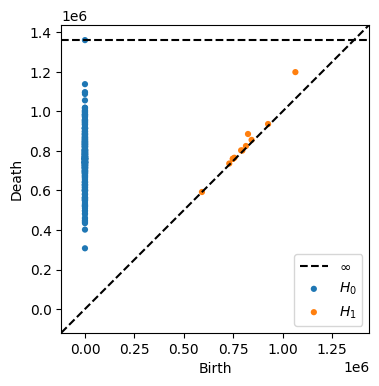

In [61]:
# make persistent homology plot with ripser
res = ripser(data, maxdim=1,  coeff =2, metric = "manhattan")
dgms = res['dgms']
plt.figure(figsize = (4,4)) 
plot_diagrams(dgms)

In [18]:
# if you want to store generated images in a file
def store_snapshots(image_ls):
    counter = 0
    for img1 in image_ls:
        img1.save("images/dataset/"+str(counter)+".png")
        counter+=1

In [56]:
store_snapshots(image_list)

In [62]:
# see how many points are persisting
H1 = res['dgms'][1].tolist() # all intervals in H1
d = []
for pair in H1: 
    d.append(pair[1] - pair[0]) # finding lengths of intervals in H1
d.sort(reverse = True) # sorting from longest to shortest intervals
d

[134130.0,
 60690.0,
 13005.0,
 12750.0,
 12240.0,
 11985.0,
 10455.0,
 9690.0,
 9435.0,
 6120.0,
 5610.0,
 255.0]